### Bi-Directional LSTM for News Classification

Here we use Bi-Directional LSTM to classify given news dataset into 4 classes:

○ World (0)
○ Sports (1)
○ Business (2)
○ Sci/Tech (3)

We have used nn.Embedding layer to learn the word embeddings instead of using any pretrained embeddings for the LSTM.

However pretrained word embeddings can be used to further boost the accuracies like word2vec, glove etc.

The vanilla LSTM Variant scores 56.8 % approx on Test Set while the Bi-Directional LSTM Variant scores 64.6 % approx on Test Set.

In [1]:
import nltk
import re
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'/home/aritra/assignments/nlp_assignment_3'

### Load the train data

In [3]:
train_set = pd.read_csv('./NLP3/train.csv')

In [4]:
train_set.head(10)

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0
5,5,France Seeks Return of Reporters in Iraq Amid ...,0
6,6,Ads Make Closing Arguments in Campaign (AP) AP...,0
7,7,Mourning for submariner spans an ocean HALIFAX...,0
8,8,"Palestinian Girl Killed in Gaza Strip, Medics ...",0
9,9,US Marine killed in Iraq #39;s western Anbar p...,0


In [5]:
print(f'Train set contains total {len(train_set)} rows with {train_set.label.unique()} unique classes(labels)')

Train set contains total 2000 rows with [0 1 2 3] unique classes(labels)


In [6]:
y_train_raw = train_set['label']

In [7]:
# y_train_raw

### Pre-Processing

In [8]:
def remove_symbols(text):
    pattern = r'[^\w\s]'  
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [9]:
def remove_stopwords(text):
    
    stopwords_set = set(stopwords.words('english'))
    text = text.split()
    stopwords_removed_text = [word for word in text if word.lower() not in stopwords_set]
    
    return ' '.join(stopwords_removed_text)

In [10]:
train_set['text'] = train_set['text'].apply(lambda x: x.lower()) 
train_set['text'] = train_set['text'].apply(remove_symbols) 
train_set['text'] = train_set['text'].apply(remove_stopwords) 
train_set['text'] = train_set['text'].apply(lambda x: x.replace('\\', ' '))
train_set['text'] = train_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [11]:
train_set.head(5)

,index,text,label
0,0,zimbabwe annual inflation drops NUM percent re...,0
1,1,NUM dead haiti NUM mass grave haiti holds NUM ...,0
2,2,seven die japan NUM pact NUM japanese police f...,0
3,3,security NUM afghan head president hamid karza...,0
4,4,palestinians say hope bush accepts dealing ara...,0


### Load the Test Data

In [12]:
test_set = pd.read_csv('./NLP3/test.csv')

In [13]:
print(f'Test set contains total {len(test_set)} rows with {test_set.label.unique()} unique classes(labels)')

Test set contains total 500 rows with [0 1 2 3] unique classes(labels)


In [14]:
y_test_raw = test_set['label']

In [15]:
test_set['text'] = test_set['text'].apply(lambda x: x.lower()) 
test_set['text'] = test_set['text'].apply(remove_symbols) 
test_set['text'] = test_set['text'].apply(remove_stopwords) 
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\\', ' ')) 
test_set['text'] = test_set['text'].replace(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', 'NUM', regex=True)

In [16]:
test_set.head()

,index,text,label
0,0,detainees seen minimal threat washington alleg...,0
1,1,japans army works plan cope north korean terro...,0
2,2,un council arrives nairobi un security council...,0
3,3,apec ministers urge new effort trade talks pac...,0
4,4,least five dead russia mine blast reuters reut...,0


### Vocabulary Creation

In [17]:
def tokenize_sentence(sentence):
    return word_tokenize(sentence)

In [18]:
sentences = train_set['text'].tolist() + test_set['text'].tolist()
len(sentences)

2500

In [19]:
tokenized_sentences = [tokenize_sentence(sentence) for sentence in sentences]

In [20]:
# Build vocabulary

vocabulary = set()
for tokens in tokenized_sentences:
    vocabulary.update(tokens)

In [21]:
# dictionary to maintain word to index mapping

word_to_idx, idx = {}, 0

for token in vocabulary:
    if token not in word_to_idx:
        word_to_idx[token] = idx
        idx += 1

In [22]:
idx_to_word = { value:key for key,value in word_to_idx.items()}

In [23]:
indexed_data = [[word_to_idx[token] for token in tokens] for tokens in tokenized_sentences]

In [24]:
# find the max length of the sentences for padding

max_seq_len = max(len(seq) for seq in indexed_data)
max_seq_len

97

In [25]:
padded_data = [seq + [0] * (max_seq_len - len(seq)) for seq in indexed_data]

In [26]:
# padded_sequence is array of all the sentences with length equal to the max_length(97) of all the sentences.

print(f'Length of the padded data train+test set is: {len(padded_data)}')

Length of the padded data train+test set is: 2500


###### Separating Train and Test Set

In [27]:
X_train = padded_data[:2000]
len(X_train)

2000

In [28]:
X_test = padded_data[2000:]
len(X_test)

500

In [29]:
# Convert to Train set to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
Y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, Y_train_tensor, test_size=0.15, random_state=42)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([1700, 97])
torch.Size([1700])
torch.Size([300, 97])
torch.Size([300])


In [32]:
# Convert to Test set to PyTorch tensors

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_raw, dtype=torch.long)

#### Dataset and Dataloader Creation

In [33]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)

In [34]:
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)

In [35]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = 2, shuffle = False)

In [36]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = ( correct/len(y_pred) ) * 100
    
    return accuracy

#### Define the Architecture

In [37]:
class vanillaLSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size, output_nodes):
        super(vanillaLSTM, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_size, batch_first = True, num_layers = 2, bidirectional = True)
        self.fc1 = nn.Linear(hidden_size * 2, output_nodes)
        self.softmax = nn.Softmax( dim = 1 )

    def forward(self, x):
        
        embedding = self.embedding_layer(x)
        output, hidden_state = self.lstm_layer(embedding)
        
        # Average pooling along the sequence dimension
        avg_pooled = torch.mean(output, dim=1)  
        output = self.fc1(avg_pooled)
        softMaxedOutput = self.softmax(output)

        return softMaxedOutput

In [38]:
# Total number of tokens we have
vocab_size = len(word_to_idx)

# Size of the embedding vector that will be created by the embedding layer
embedding_size = 100

# no. of nodes in the RNN Layer
hidden_size = 128

# Number of classes
output_size = 4  

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [40]:
vanillaLSTM = vanillaLSTM(vocab_size, embedding_size, hidden_size, output_size).to(device)
vanillaLSTM

vanillaLSTM(
  (embedding_layer): Embedding(13628, 100)
  (lstm_layer): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [41]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vanillaLSTM.parameters(), lr=0.0009)

##### Training Loop

In [42]:
num_epochs = 30
performance_metrics = []
best_val_accuracy = 0

for epoch in tqdm(range(num_epochs)):
    
    vanillaLSTM.train()
    train_loss = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = vanillaLSTM(X)
                
        # calculate batch accumulative loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    with torch.inference_mode():
        
        vanillaLSTM.eval()
        val_loss, val_accuracy = 0,0
        
        for X_val, y_val in val_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            y_val_pred = vanillaLSTM(X_val)
            
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss
            val_accuracy += accuracy_fn(y_val, y_val_pred.argmax(dim=1))
        
        # Calculate avg. loss & accuracy
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        
        print(f"Epoch:{epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_accuracy:.3f}")
        performance_metrics.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            torch.save(vanillaLSTM.state_dict(), './best_LSTM_model.pt')
            print('Model State Saved\n')
            best_val_accuracy = val_accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:1 | Train loss: 1.3870 | Val loss: 1.3786 | Val accuracy: 32.127
Model State Saved

Epoch:2 | Train loss: 1.2856 | Val loss: 1.2948 | Val accuracy: 42.763
Model State Saved

Epoch:3 | Train loss: 1.1597 | Val loss: 1.1997 | Val accuracy: 53.509
Model State Saved

Epoch:4 | Train loss: 1.1623 | Val loss: 1.3357 | Val accuracy: 39.035
Epoch:5 | Train loss: 1.0673 | Val loss: 1.1793 | Val accuracy: 55.154
Model State Saved

Epoch:6 | Train loss: 0.9617 | Val loss: 1.1686 | Val accuracy: 56.689
Model State Saved

Epoch:7 | Train loss: 0.9556 | Val loss: 1.1487 | Val accuracy: 58.553
Model State Saved

Epoch:8 | Train loss: 0.9243 | Val loss: 1.1310 | Val accuracy: 59.430
Model State Saved

Epoch:9 | Train loss: 0.8880 | Val loss: 1.1243 | Val accuracy: 60.197
Model State Saved

Epoch:10 | Train loss: 0.8637 | Val loss: 1.0964 | Val accuracy: 63.487
Model State Saved

Epoch:11 | Train loss: 0.8403 | Val loss: 1.0956 | Val accuracy: 64.474
Model State Saved

Epoch:12 | Train loss: 0.82

#### Records

Best 28.36 % with AdamW = 0.005, hidden_size = 512

Best 31.4 % with AdamW = 0.0009, hidden_size = 512

### Evaluation on Test Set

In [43]:
# Load the model state doctionary saved above.

y_predicted_list, y_test_true = [],[]

vanillaLSTM.load_state_dict(torch.load('./best_LSTM_model.pt'))

with torch.inference_mode():
    vanillaLSTM.eval()
    test_loss, test_accuracy = 0,0

    for X_test, y_test in tqdm(test_loader):

        X_test, y_test = X_test.to(device), y_test.to(device)

        y_test_pred = vanillaLSTM(X_test)
        
        y_predicted_list.append(y_test_pred.argmax(dim = 1))
        y_test_true.append(y_test)

        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss
        test_accuracy += accuracy_fn(y_test, y_test_pred.argmax(dim=1))

    # Calculate avg. loss & accuracy
    test_loss = test_loss/len(test_loader)
    test_accuracy = test_accuracy/len(test_loader)

    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.2f}")

  0%|          | 0/250 [00:00<?, ?it/s]

Test loss: 1.0415 | Test accuracy: 69.60


#### Test Accuracy of the Bi-LSTM Model

In [44]:
print(f'Test Accuracy for the BERT Sequence Classifier model is: {test_accuracy:.2f} %')

Test Accuracy for the BERT Sequence Classifier model is: 69.60 %


In [45]:
# Convert the list of tensors to a single list of elements

y_predicted_list = [item for tensor in y_predicted_list for item in tensor.tolist()]
y_test_true = [item for tensor in y_test_true for item in tensor.tolist()]

#### F-1 Score

In [46]:
f1 = f1_score(np.array(y_test_true), np.array(y_predicted_list), average='weighted')
print(f'F1 Score for the model is: {f1:.4f}')

F1 Score for the model is: 0.6953


#### Confusion Matrix

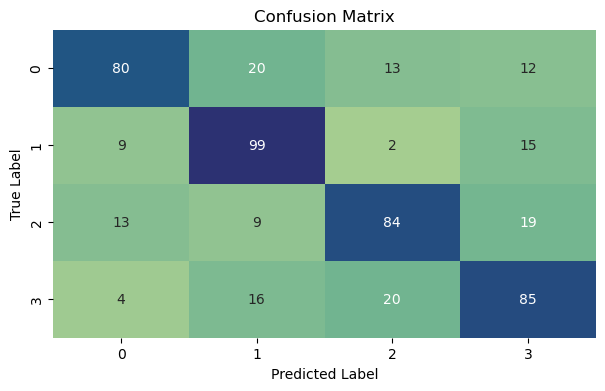

In [47]:
# Calculate confusion matrix
cm = confusion_matrix(y_test_true, y_predicted_list)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()